# Code Assistant

The goal of the demo is to build a code assistant using Langgraph that is able to create a function based on user prompt and recursively improve it until it can be run.

In [1]:
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup API key and LLM model

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [45]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [61]:
MAX_ITERATIONS = 3

## Create the nodes

### Code generation

In [78]:
from pydantic import BaseModel, Field

# Code data model
class Code(BaseModel):
    prefix: str = Field(description="Description of the code generating task.")
    imports: str = Field(description="Import statements.")
    code: str = Field(description="Code block.")

# Initial system and code generation prompt

system_prompt = """You are an experienced Python software developer. You help with function implementation. Always create your code in Python."""

code_prompt = """Please help implementing a function based on the prompt provided to you.
Here are the details of the prompt: \nDescription of the function: {task}\nInput parameters: {params}\nReturn parameter: {result}\n
Ensure any code you provide can be executed with all imports. Structure your answer with a description of the function, the list of imports, and the functioning code block."""

# Create agent
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm = llm.with_structured_output(Code)

In [47]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

#### Test run of coding assistant

In [80]:
task = "Help me implement a function that calculates the area of a circle."
params = "r: float"
result =  "area of circle as a float"

circle_area_prompt = code_prompt.format(task=task, params=params, result=result)

circle_area_function = llm.invoke([SystemMessage(content=system_prompt)] + [HumanMessage(content=circle_area_prompt)])
circle_area_function

Code(prefix='This function calculates the area of a circle given its radius. The formula to calculate the area of a circle is A = πr², where A is the area and r is the radius of the circle. The function takes a single input parameter, r, which is the radius of the circle, and returns the area as a float.', imports='import math', code='def calculate_circle_area(r: float) -> float:\n    return math.pi * r ** 2')

#### Create graph state

In [48]:
from typing import List, Annotated
from typing_extensions import TypedDict
from operator import add

class GraphState(TypedDict):
    messages: Annotated[List[AIMessage | HumanMessage | SystemMessage], add] 
    error: int
    generation: Code
    iterations:int

#### Code generation node

In [60]:
def generate_code(state: GraphState):
    
    print("---GENERATING CODE SOLUTION---")

    #error = state["error"]
    iterations = state["iterations"]

    solution = llm.invoke(state["messages"])

    ai_message = AIMessage(content="prefix= {}, imports= {}, code= {}".format(solution.prefix, solution.imports, solution.code))
    iterations += 1

    return {"messages": [ai_message], "generation": solution, "iterations": iterations}

#### Code checking node

In [67]:
def check_code(state: GraphState):

    print("---CHECKING CODE SOLUTION---")

    solution_imports = state["generation"].imports
    solution_code = state["generation"].code

    update_message = "Please try again to create the solution. Take into consideration the error message and follow the initial user prompt."

    try:
        exec(solution_imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = HumanMessage(content="Your solution failed the import test: {}\n{}. ".format(e, update_message))
        return {"messages": [error_message], "error" : 1}

    try:
        exec(solution_imports + "\n" + solution_code)
    except Exception as e:
        print("---CODE CHECK: FAILED---")
        error_message = HumanMessage(content="Your solution failed the code execution test: {}\n{}".format(e, update_message))
        return {"messages": [error_message], "error" : 1}

    print("---NO CODE TEST FAILURES---")
    return {"error": 0}


#### Conditional edges

In [68]:
def finish(state: GraphState):

    if state["error"] == 0 or state["iterations"] == MAX_ITERATIONS:
        print("---DECISION: FINISH---")
        return "END"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate_code"

## Create the graph

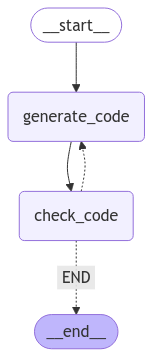

In [74]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(GraphState)

builder.add_node("generate_code", generate_code)
builder.add_node("check_code", check_code)

builder.add_edge(START, "generate_code")
builder.add_edge("generate_code", "check_code")
builder.add_conditional_edges("check_code", finish, {"generate_code": "generate_code", "END": END})

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [81]:
graph_result = graph.invoke({"messages": [SystemMessage(content=system_prompt)] + [HumanMessage(content=circle_area_prompt)],
                            "iterations": 0})
graph_result

---GENERATING CODE SOLUTION---
---CHECKING CODE SOLUTION---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'messages': [SystemMessage(content='You are an experienced Python software developer. You help with function implementation. Always create your code in Python.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Please help implementing a function based on the prompt provided to you.\nHere are the details of the prompt: \nDescription of the function: Help me implement a function that calculates the area of a circle.\nInput parameters: r: float\nReturn parameter: area of circle as a float\n\nEnsure any code you provide can be executed with all imports. Structure your answer with a description of the function, the list of imports, and the functioning code block.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='prefix= This function calculates the area of a circle given its radius., imports= import math, code= def calculate_circle_area(r: float) -> float:\n    return math.pi * (r ** 2)', additional_kwargs={}, response_metadata={})],
 'error': 0,
 'ge

In [90]:
task = "Write a function that imports module X It uses X.add() to add two numbers."
params = "x: int, y: int"
result =  "x+y"

test_prompt = code_prompt.format(task=task, params=params, result=result)

graph_result = graph.invoke({"messages": [SystemMessage(content=system_prompt)] + [HumanMessage(content=test_prompt)],
                            "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE SOLUTION---
---CODE IMPORT CHECK: FAILED---
---DECISION: RE-TRY SOLUTION---
---GENERATING CODE SOLUTION---
---CHECKING CODE SOLUTION---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


In [91]:
graph_result

{'messages': [SystemMessage(content='You are an experienced Python software developer. You help with function implementation. Always create your code in Python.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Please help implementing a function based on the prompt provided to you.\nHere are the details of the prompt: \nDescription of the function: Write a function that imports module X It uses X.add() to add two numbers.\nInput parameters: x: int, y: int\nReturn parameter: x+y\n\nEnsure any code you provide can be executed with all imports. Structure your answer with a description of the function, the list of imports, and the functioning code block.', additional_kwargs={}, response_metadata={}),
  AIMessage(content="prefix= This function imports a module named 'X' and uses its 'add' method to add two numbers. The function takes two integer inputs, 'x' and 'y', and returns their sum using the 'add' method from module 'X'., imports= import X, code= def add_numbers(